# Perguntas do Projeto baseado nos dados do AdventureWorks

7 - A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

8 - Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.

9 - Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 7?

10 - Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

# Instalação

In [71]:
!pip install pmdarima

In [72]:
!pip install -U numba hierarchicalforecast statsforecast datasetsforecast

In [73]:
!pip install neuralforecast

# Importes

In [74]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pmdarima import arima
from pmdarima import utils

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

import warnings
warnings.filterwarnings('ignore')
from hierarchicalforecast.utils import aggregate
from neuralforecast.losses.numpy import mae, mse, rmse

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [2]:
current_directory = Path.cwd()
relative_path = Path('order_sales_data.csv')
absolute_path = current_directory / relative_path

data = pd.read_csv(absolute_path)

/tmp/ipykernel_18028/487152554.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(absolute_path)


In [3]:
data.columns

Index(['order_id', 'order_date', 'store_name', 'product_category_name',
       'product_subcategory_name', 'product_name', 'order_qty',
       'online_order_flag', 'state_province_name', 'country_region_name',
       'territory_name'],
      dtype='object')

In [9]:
data.shape

(131863, 11)

In [10]:
data.head(2)

,order_id,order_date,store_name,product_category_name,product_subcategory_name,product_name,order_qty,online_order_flag,state_province_name,country_region_name,territory_name
0,59005,2013-10-30,Summer Sports Place,Components,Saddles,LL Mountain Seat/Saddle,1,False,Illinois,United States,Central
1,51796,2013-06-30,Bike Products and Accessories,Accessories,Tires and Tubes,Patch Kit/8 Patches,3,False,Virginia,United States,Southeast


In [11]:
data.isnull().sum()

,0
order_id,0
order_date,0
store_name,70944
product_category_name,0
product_subcategory_name,0
product_name,0
order_qty,0
online_order_flag,0
state_province_name,0
country_region_name,0


# Pré Processamento

## Verificação de store_names ausentes e sua relação com compras online

In [12]:
filtered_store_name_null = data[data['store_name'].isnull()]

# verifica se foram compras do tipo online
all_online = (filtered_store_name_null['online_order_flag'] == 1).all()

if all_online:
    print("Sim, todos os pedidos com store_name vazio são do tipo compras online")
else:
    print("Não, nem todos os pedidos com store_name vazio são do tipo compras online")

Sim, todos os pedidos com store_name vazio são do tipo compras online


A coluna 'store_name' será preenchida com o valor 'online' para os registros em que a flag 'online_order_flag' é 'True'. Isso indica que a compra foi realizada na loja online.

In [13]:
data.loc[data['online_order_flag'] == True, 'store_name'] = 'online'

In [14]:
data['order_date'] = pd.to_datetime(data['order_date'])

In [15]:
data.dtypes

,0
order_id,int64
order_date,datetime64[ns]
store_name,object
product_category_name,object
product_subcategory_name,object
product_name,object
order_qty,int64
online_order_flag,bool
state_province_name,object
country_region_name,object


# Análise

In [16]:
df = data.copy()

 definir a data como indice
 agrupar dados por mes
 plotar a serie por quantidade de produtos vendiidos no geral

In [17]:
df = df.sort_values('order_date')

df.set_index('order_date', inplace=True)

df_grouped = df.resample('M').sum()

## Produtos mais vendidos

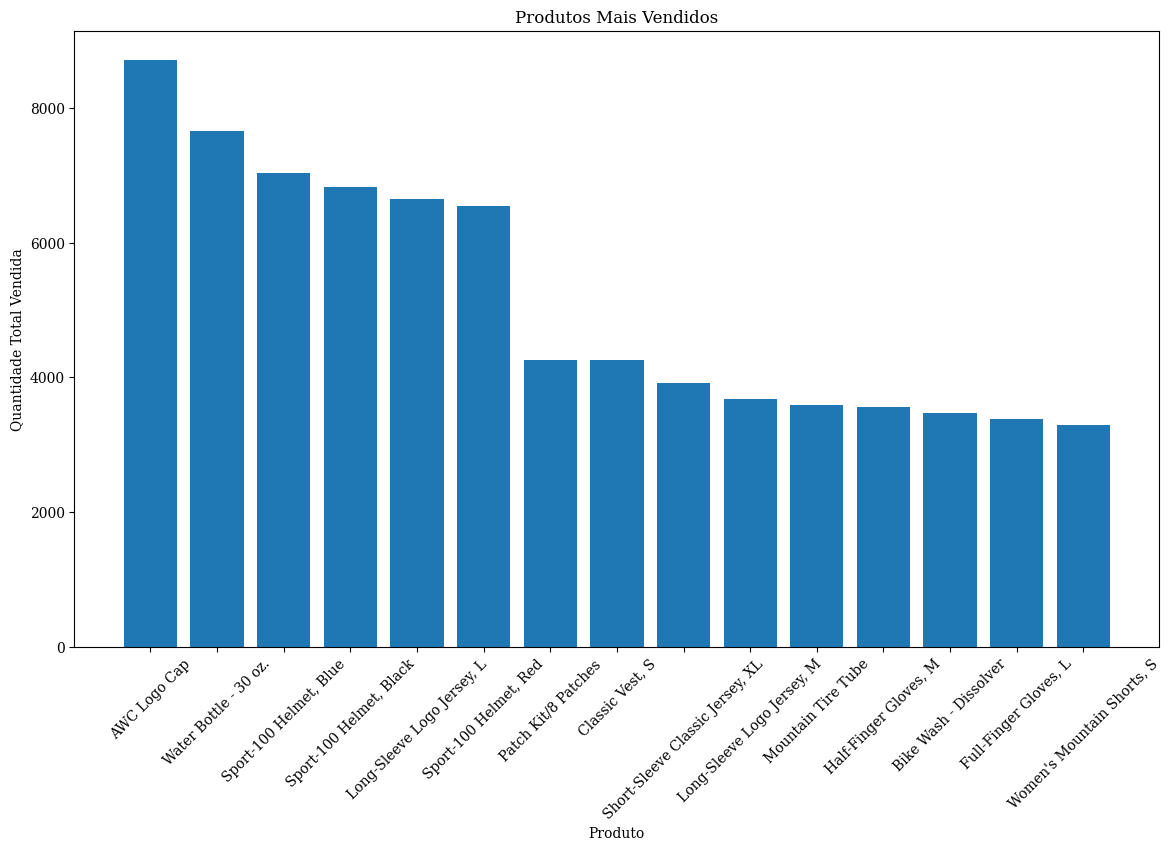

In [18]:
product_sales = df.groupby('product_name')['order_qty'].sum().reset_index()
product_sales = product_sales.sort_values(by='order_qty', ascending=False)
top_products = product_sales.head(15)

plt.figure(figsize=(14, 8))
plt.bar(top_products['product_name'], top_products['order_qty'])

plt.title('Produtos Mais Vendidos')
plt.xlabel('Produto')
plt.ylabel('Quantidade Total Vendida')

plt.xticks(rotation=45)
plt.show()

## Lojas com maior número de vendas

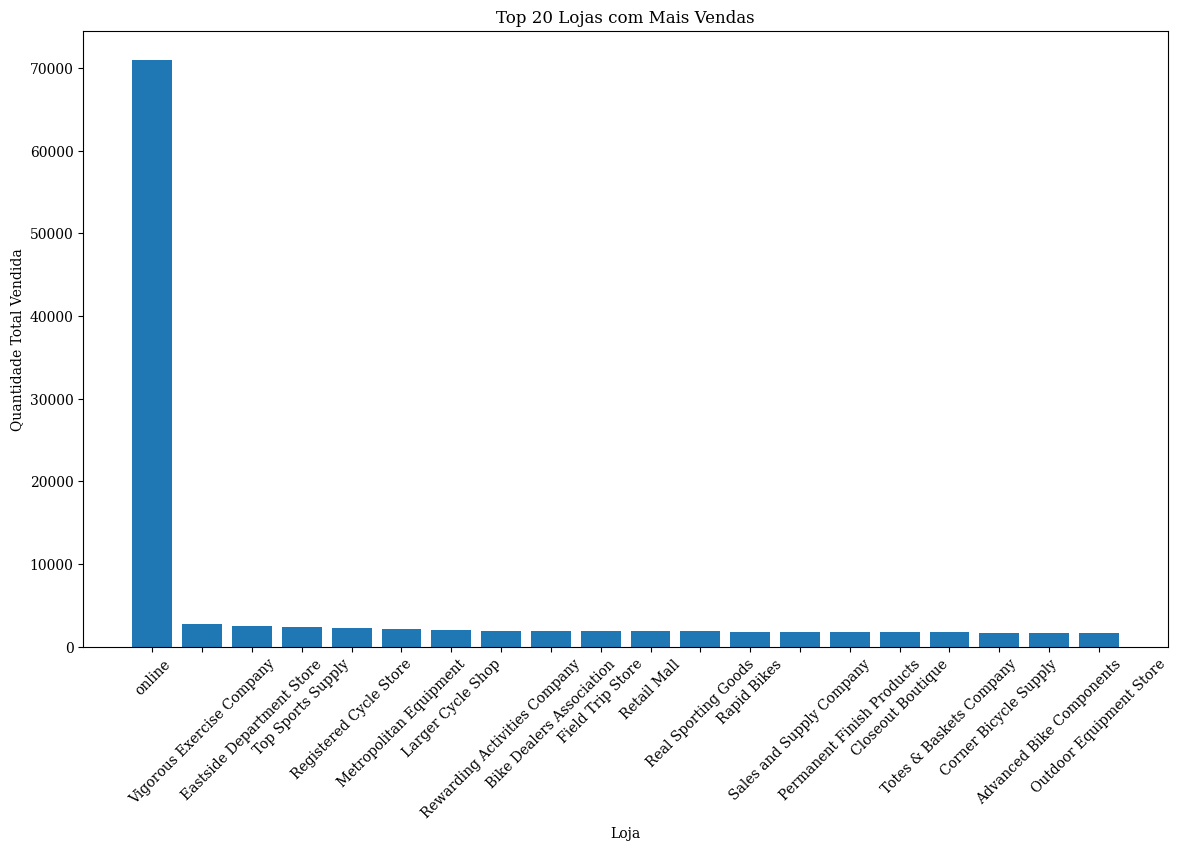

In [19]:
store_sales = df.groupby('store_name')['order_qty'].sum().reset_index()

store_sales = store_sales.sort_values(by='order_qty', ascending=False)

top_stores = store_sales.head(20)

plt.figure(figsize=(14, 8))
plt.bar(top_stores['store_name'], top_stores['order_qty'])

plt.title('Top 20 Lojas com Mais Vendas')
plt.xlabel('Loja')
plt.ylabel('Quantidade Total Vendida')

plt.xticks(rotation=45)

plt.show()

Maior quantidade de vendas provem de lojas online

## Análise temporal

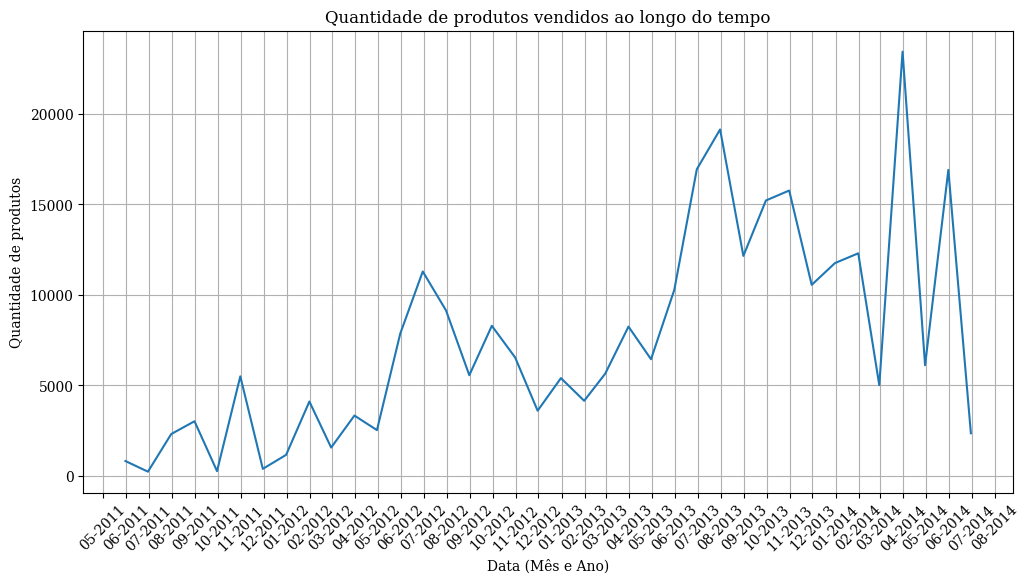

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped['order_qty'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.xticks(rotation=45)

plt.title('Quantidade de produtos vendidos ao longo do tempo')
plt.xlabel('Data (Mês e Ano)')
plt.ylabel('Quantidade de produtos')
plt.grid(True)

plt.show()

## Decomposição das Vendas

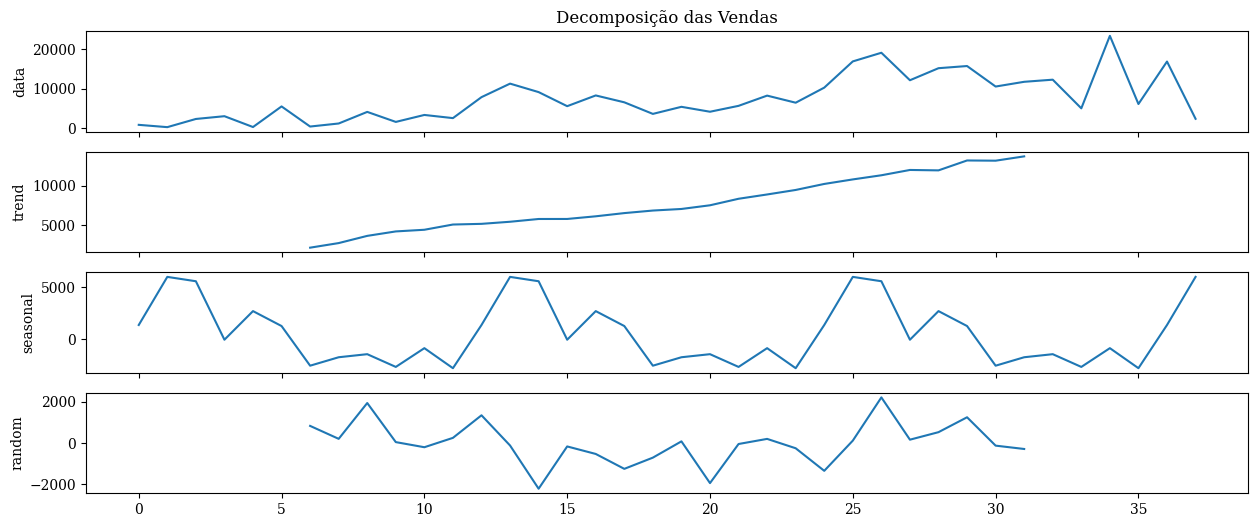

In [21]:
values = df_grouped['order_qty'].values

# Para 12 meses
decomposed = arima.decompose(values, 'additive', m=12)

figure_kwargs = {'figsize': (15, 6)}

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Decomposição das Vendas")
plt.show()

# Modelo

## Diagrama de níveis

Nível hierarquico considerado

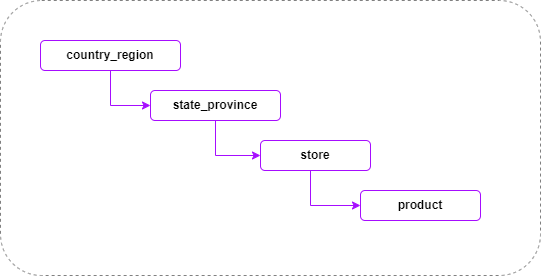

## Serie Hierárquica

A série temporal hierárquica é ideal para prever a demanda de produtos em cada loja porque permite analisar e integrar dados em diferentes níveis (global, produto, loja).


In [22]:
df_ts = data.copy()

In [23]:
df_ts.columns

Index(['order_id', 'order_date', 'store_name', 'product_category_name',
       'product_subcategory_name', 'product_name', 'order_qty',
       'online_order_flag', 'state_province_name', 'country_region_name',
       'territory_name'],
      dtype='object')

In [24]:
columns_ts = ['store_name', 'product_name', 'order_qty',
              'order_date', 'territory_name', 'country_region_name',
              'state_province_name']

df_ts = df_ts[columns_ts]

In [25]:
min_date = df_ts['order_date'].min().date()
max_date = df_ts['order_date'].max().date()

print(f"A menor data é: {min_date}")
print(f"A maior data é: {max_date}")

A menor data é: 2011-05-31
A maior data é: 2014-06-30


In [26]:
df_ts['month'] = pd.to_datetime(df_ts['order_date']).dt.to_period('M').dt.to_timestamp()

In [27]:
hts = (
    df_ts.groupby(['month', 'product_name', 'store_name', 'state_province_name', 'country_region_name'])['order_qty'].sum()
    .reset_index()
)

In [28]:
hts.head(3)

,month,product_name,store_name,state_province_name,country_region_name,order_qty
0,2011-05-01,AWC Logo Cap,Area Bike Accessories,California,United States,3
1,2011-05-01,AWC Logo Cap,Better Bike Shop,Georgia,United States,2
2,2011-05-01,AWC Logo Cap,Bike Dealers Association,New Mexico,United States,6


In [29]:
hts.shape

(77722, 6)

Definir hierarquias

In [30]:
hierarchies = [
    ['country_region_name'],
    ['country_region_name', 'state_province_name'],
    ['country_region_name', 'state_province_name', 'store_name'],
    ['country_region_name', 'state_province_name', 'store_name', 'product_name']
]

In [31]:
hts = hts.rename(columns={"month": "ds", "order_qty": "y"})
hts['ds'] = pd.to_datetime(hts['ds'])

In [32]:
Y_df, S_df, tags = aggregate(hts, hierarchies)

In [33]:
Y_df.index.value_counts()

,count
unique_id,
Australia,38
Canada/British Columbia,38
Canada/British Columbia/online,38
United States/Oregon/online,38
United States/Washington,38
...,...
"United States/Montana/Nonskid Tire Company/Mountain-500 Silver, 52",1
"United States/Montana/Nonskid Tire Company/Mountain-500 Silver, 48",1
"United States/Montana/Nonskid Tire Company/Mountain-500 Silver, 42",1


In [34]:
Y_df = Y_df.reset_index()

In [35]:
Y_df

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,101
2,Australia,2011-07-01,112
3,Australia,2011-08-01,98
4,Australia,2011-09-01,109
...,...,...,...
84603,United States/Wyoming/online/Mountain-200 Silv...,2013-07-01,1
84604,United States/Wyoming/online/Patch Kit_8 Patches,2013-07-01,1
84605,"United States/Wyoming/online/Road-150 Red, 52",2012-03-01,2
84606,United States/Wyoming/online/Road-550-W Yellow...,2014-03-01,1


In [36]:
Y_df_reg = Y_df.copy()

### Divisão em treino e teste

In [37]:
Y_df.head(3)

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,101
2,Australia,2011-07-01,112


In [38]:
Y_df.tail(3)

,unique_id,ds,y
84605,"United States/Wyoming/online/Road-150 Red, 52",2012-03-01,2
84606,United States/Wyoming/online/Road-550-W Yellow...,2014-03-01,1
84607,"United States/Wyoming/online/Sport-100 Helmet,...",2014-03-01,1


Para previsão dos últimos 3 meses

In [39]:
Y_test_df = Y_df.groupby('unique_id').tail(3)
Y_train_df = Y_df.drop(Y_test_df.index)

Os modelos Naive e AutoARIMA foram escolhidos devido à sua robustez em situações com dados ausentes e à capacidade de lidar com a heterogeneidade no número de observações por grupo:

- Naive: Tem capacidade de operar mesmo com dados esparsos. Será utilizado como baseline. O modelo Naive fornece um ponto de referência inicial simples, permitindo comparar se os modelos mais avançados oferecem melhorias significativas em relação a essa linha de base mínima.

- AutoARIMA: Eficaz em modelar padrões e sazonalidades mesmo quando há variações no número de observações.

In [40]:
fcst = StatsForecast(df=Y_train_df,
                     models=[
                         Naive(),
                         AutoARIMA(season_length=12),
                         ],
                    freq='MS',
                    n_jobs=-1
                   )

Y_hat_df = fcst.forecast(h=3)

In [41]:
Y_hat_df_2 = Y_hat_df.reset_index()
Y_test_df_2 = Y_test_df

In [42]:
# Y_hat_df_2.head()

In [43]:
Y_test_df_2.head()

,unique_id,ds,y
35,Australia,2014-04-01,1206
36,Australia,2014-05-01,2342
37,Australia,2014-06-01,401
73,Canada,2014-04-01,755
74,Canada,2014-05-01,2764


In [44]:
Y_hat_df.shape

(28827, 3)

In [45]:
Y_test_df.shape

(56893, 3)

In [46]:
# Tabela com os valores reais e previstos
predictions = pd.merge(
    Y_test_df, Y_hat_df_2,
    on=['unique_id', 'ds'],
    how='left',
    indicator=True
).query('_merge == "both"').drop(columns='_merge')

predictions.head()

,unique_id,ds,y,Naive,AutoARIMA
0,Australia,2014-04-01,1206,1694.0,1968.920654
1,Australia,2014-05-01,2342,1694.0,1231.753906
2,Australia,2014-06-01,401,1694.0,1808.967651
3,Canada,2014-04-01,755,3601.0,2004.988403
4,Canada,2014-05-01,2764,3601.0,1960.586060


In [47]:
predictions.tail(5)

,unique_id,ds,y,Naive,AutoARIMA
56840,United States/Wyoming/Great Bikes /Women's Mou...,2013-08-01,2,2.0,2.0
56843,United States/Wyoming/Great Bikes /Women's Mou...,2013-08-01,14,18.0,18.0
56849,United States/Wyoming/Great Bikes /Women's Tig...,2012-08-01,5,5.0,5.0
56868,United States/Wyoming/Some Discount Store/Moun...,2011-10-01,4,2.0,2.0
56871,United States/Wyoming/Some Discount Store/Moun...,2011-10-01,5,5.0,5.0


In [48]:
predictions.columns

Index(['unique_id', 'ds', 'y', 'Naive', 'AutoARIMA'], dtype='object')

Quantidade prevista para cada nível


In [49]:
predictions\
    .reset_index()\
    .assign(
        hierarchy_level=lambda x: x['unique_id'].str.count('/') + 1
    )\
    .groupby('hierarchy_level')[['Naive', 'AutoARIMA']]\
    .sum()

,Naive,AutoARIMA
hierarchy_level,,
1,70302.0,50962.183594
2,48438.0,37200.062500
3,65049.0,47555.222656
4,53693.0,42500.710938


### Métricas de avaliação

In [50]:
df_merged = pd.merge(
    Y_test_df[['unique_id', 'ds', 'y']],
    Y_hat_df_2[['unique_id', 'ds', 'AutoARIMA', 'Naive']],
    on=['unique_id', 'ds'],
    how='inner'
)

In [51]:
df_merged.head()

,unique_id,ds,y,AutoARIMA,Naive
0,Australia,2014-04-01,1206,1968.920654,1694.0
1,Australia,2014-05-01,2342,1231.753906,1694.0
2,Australia,2014-06-01,401,1808.967651,1694.0
3,Canada,2014-04-01,755,2004.988403,3601.0
4,Canada,2014-05-01,2764,1960.586060,3601.0


In [52]:
y_true = df_merged['y'].values
y_hat_autoarima = df_merged['AutoARIMA'].values
y_hat_naive = df_merged['Naive'].values

# Calculate MAE, MSE, and RMSE
mae_autoarima = mae(y_true, y_hat_autoarima)
mse_autoarima = mse(y_true, y_hat_autoarima)
rmse_autoarima = rmse(y_true, y_hat_autoarima)

mae_naive = mae(y_true, y_hat_naive)
mse_naive = mse(y_true, y_hat_naive)
rmse_naive = rmse(y_true, y_hat_naive)

In [53]:
metric_table = pd.DataFrame({
    'Model': ['AutoARIMA', 'Naive'],
    'MAE': [mae_autoarima, mae_naive],
    'MSE': [mse_autoarima, mse_naive],
    'RMSE': [rmse_autoarima, rmse_naive]
})

metric_table

,Model,MAE,MSE,RMSE
0,AutoARIMA,9.830797,15226.292063,123.394862
1,Naive,11.519171,27072.949482,164.538596


### 7.1 - Visualização temporal da previsão

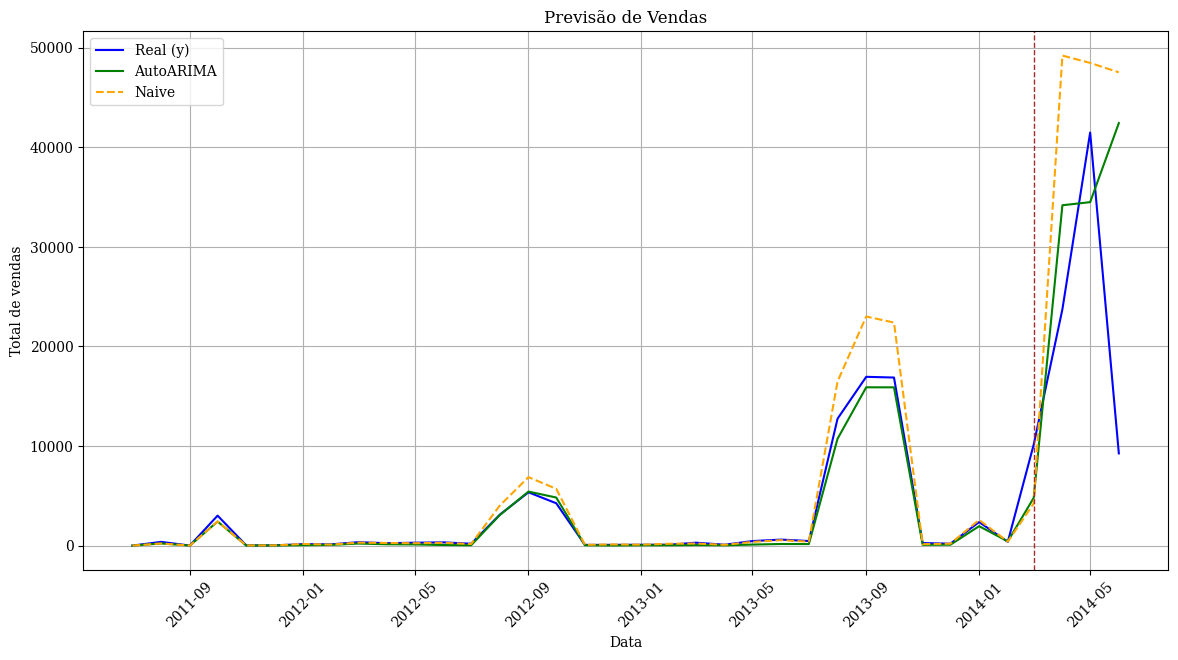

In [125]:
df = predictions.copy()
df['ds'] = pd.to_datetime(df['ds'])

df_grouped = df.groupby(df['ds'].dt.to_period('M')).agg({
    'y': 'sum',
    'AutoARIMA': 'sum',
    'Naive': 'sum'
}).reset_index()

df_grouped['ds'] = df_grouped['ds'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(df_grouped['ds'], df_grouped['y'], label='Real (y)', color='blue')
plt.plot(df_grouped['ds'], df_grouped['AutoARIMA'], label='AutoARIMA', color='green')
plt.plot(df_grouped['ds'], df_grouped['Naive'], label='Naive', color='orange', linestyle='--')

# Adicionar marcador onde inicia os 3 meses finais
end_date = df_grouped['ds'].max()
start_date = end_date - pd.DateOffset(months=3)
plt.axvline(x=start_date, color='brown', linestyle='--', linewidth=1)

plt.title("Previsão de Vendas")
plt.xlabel("Data")
plt.ylabel("Total de vendas")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

O AutoArima, se aproxima um pouco mais da demanda real

## Analisar sazonalidade de produtos

Para abordar a questão de sazonalidade na previsão de demanda, será analisado o produto mais vendido, pois entender seu comportamento pode ser estratégico para a empresa.

In [55]:
saz = predictions.copy()

In [56]:
top_products

,product_name,order_qty
0,AWC Logo Cap,8709
259,Water Bottle - 30 oz.,7655
232,"Sport-100 Helmet, Blue",7033
231,"Sport-100 Helmet, Black",6824
103,"Long-Sleeve Logo Jersey, L",6651
233,"Sport-100 Helmet, Red",6551
177,Patch Kit/8 Patches,4264
7,"Classic Vest, S",4260
230,"Short-Sleeve Classic Jersey, XL",3919
104,"Long-Sleeve Logo Jersey, M",3686


In [57]:
filtered_df = saz[saz['unique_id'].str.contains('AWC Logo Cap', case=False, na=False)]

In [58]:
filtered_df

,unique_id,ds,y,Naive,AutoARIMA
2190,Australia/New South Wales/Bike Part Wholesaler...,2013-10-01,7,6.0,6.000000
2750,Australia/New South Wales/Nationwide Supply/AW...,2013-10-01,18,16.0,16.000000
2926,Australia/New South Wales/Popular Bike Lines/A...,2013-10-01,6,8.0,8.000000
3242,Australia/New South Wales/online/AWC Logo Cap,2014-04-01,20,20.0,17.435928
3243,Australia/New South Wales/online/AWC Logo Cap,2014-05-01,26,20.0,15.200580
...,...,...,...,...,...
55954,United States/Washington/online/AWC Logo Cap,2014-04-01,24,18.0,18.000000
55955,United States/Washington/online/AWC Logo Cap,2014-05-01,21,18.0,18.000000
55956,United States/Washington/online/AWC Logo Cap,2014-06-01,9,18.0,18.000000
56350,United States/Wisconsin/Good Bike Shop/AWC Log...,2012-10-01,4,3.0,0.000000


### Vendas do producto AWC Logo Cap ao longo do tempo

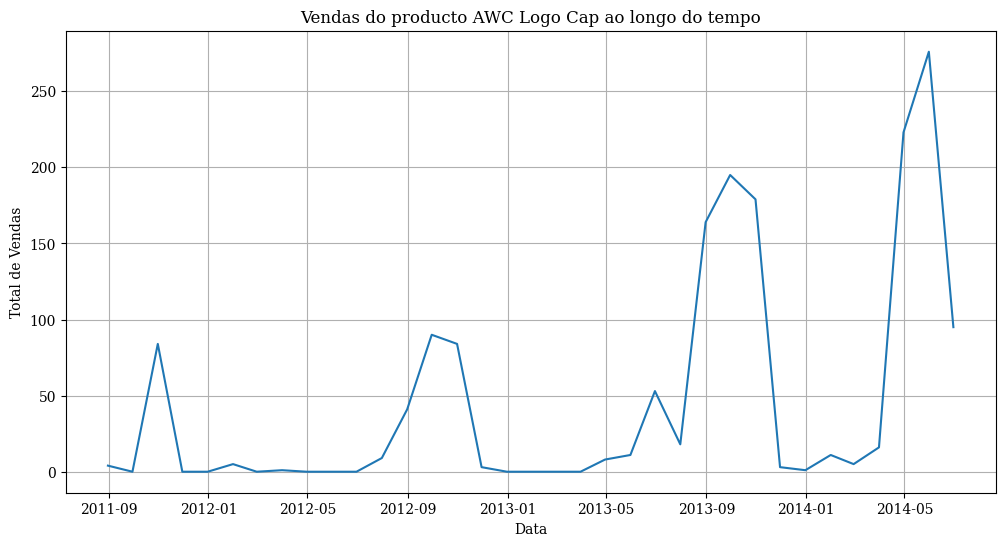

In [59]:
df_product = filtered_df.copy()

df_product.set_index('ds', inplace=True)

monthly_sales = df_product['y'].resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Vendas do producto AWC Logo Cap ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.grid(True)
plt.show()

### 7.2 - Decomposição das vendas

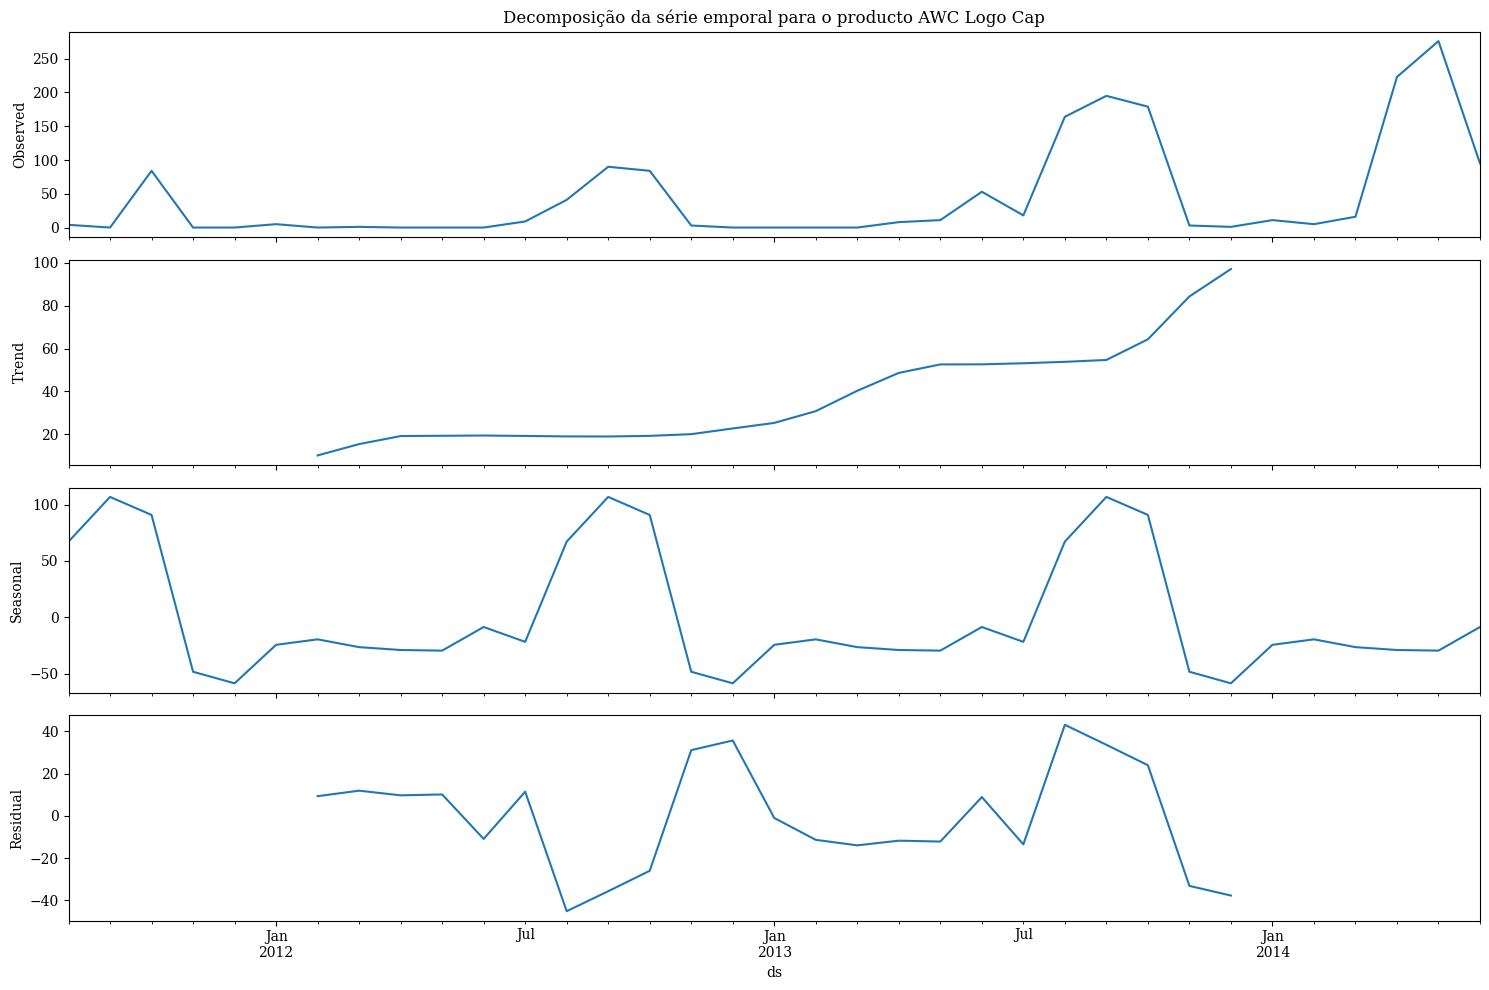

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
filtered_df = filtered_df.reset_index()
filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])

filtered_df.set_index('ds', inplace=True)
monthly_data = filtered_df.resample('M').sum()

def plot_seasonal_decomposition(series, title, freq):
    decomposition = seasonal_decompose(series, model='additive', period=freq)
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title=title)
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_ylabel('Seasonal')
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_ylabel('Residual')
    plt.tight_layout()
    plt.show()

plot_seasonal_decomposition(monthly_data['y'], 'Decomposição da série emporal para o producto AWC Logo Cap', freq=12)

O gráfico de sazonalidade revelou um padrão claro, com amplitude de aproximadamente 100 unidades. As vendas máximas do produto alcançam 250 unidades, com picos menores próximos de 100 unidades, indicando que a amplitude sazonal representa cerca de 40% do pico máximo de vendas.

**Esse comportamento visual, aliado à amplitude sazonal observada no gráfico de decomposição, indica a presença de sazonalidade nas vendas do produto AWC Logo Cap.**

O padrão sazonal ocorre tipicamente em outubro e novembro, coincidentemente com períodos de alta demanda, como o final do ano, Black Friday e festividades de Natal, momentos em que as vendas aumentam significativamente.

## 8 - Regressão

 - Com os dados já hierarquizados nos diferentes níveis, utilizaremos o XGBoost Regressor devido à sua capacidade superior de modelar relações complexas e não lineares.

- Para garantir que a divisão dos dados por nível hierárquico seja adequada, cada grupo deve possir pelo menos 4 registros.

- Isso assegura que há dados suficientes para o treinamento e validação do modelo em cada nível hierárquico

In [95]:
min_samples = 4
Y_reg = Y_df_reg.groupby('unique_id').filter(lambda x: len(x) >= min_samples)

In [96]:
df_reg = Y_reg.reset_index(drop=True)

In [97]:
df_reg.head()

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,101
2,Australia,2011-07-01,112
3,Australia,2011-08-01,98
4,Australia,2011-09-01,109


In [98]:
df_reg.tail()

,unique_id,ds,y
56537,United States/Wyoming/Some Discount Store/Moun...,2012-03-01,1
56538,United States/Wyoming/Some Discount Store/Moun...,2011-07-01,5
56539,United States/Wyoming/Some Discount Store/Moun...,2011-10-01,5
56540,United States/Wyoming/Some Discount Store/Moun...,2012-01-01,1
56541,United States/Wyoming/Some Discount Store/Moun...,2012-03-01,1


In [99]:
df_reg['ds'] = pd.to_datetime(df_reg['ds'])

df_reg['month'] = df_reg['ds'].dt.month
df_reg['year'] = df_reg['ds'].dt.year

Definir features de defasagem para capturar dependências temporais (lags)

In [100]:
df_reg['y_lag1'] = df_reg.groupby('unique_id')['y'].shift(1)
df_reg['y_lag2'] = df_reg.groupby('unique_id')['y'].shift(2)

In [101]:
Y_test_df = df_reg.groupby('unique_id').tail(3)
Y_train_df = df_reg.drop(Y_test_df.index)

In [102]:
col_reg = ['unique_id', 'month', 'year', 'y_lag1', 'y_lag2']

X_train = Y_train_df[col_reg]
y_train = Y_train_df['y']
X_test = Y_test_df[col_reg]
y_test = Y_test_df['y']

In [103]:
encoder = LabelEncoder()

# Codificar 'unique_id' como variável categórica
X_train['unique_id'] = encoder.fit_transform(X_train['unique_id'])
X_test['unique_id'] = encoder.transform(X_test['unique_id'])

In [104]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

### Métricas de avaliação

In [105]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_df = pd.DataFrame({
    'Model': ['XGBoostRegressor'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

metrics_df

,Model,MAE,MSE,RMSE
0,XGBoostRegressor,8.217783,10785.317487,103.852383


In [106]:
Y_test_df['y_pred'] = y_pred

# Agrupar os dados por mês e ano para o gráfico
Y_test_df['month_year'] = Y_test_df['ds'].dt.to_period('M')
grouped_results = Y_test_df.groupby('month_year').agg({'y': 'sum', 'y_pred': 'sum'}).reset_index()

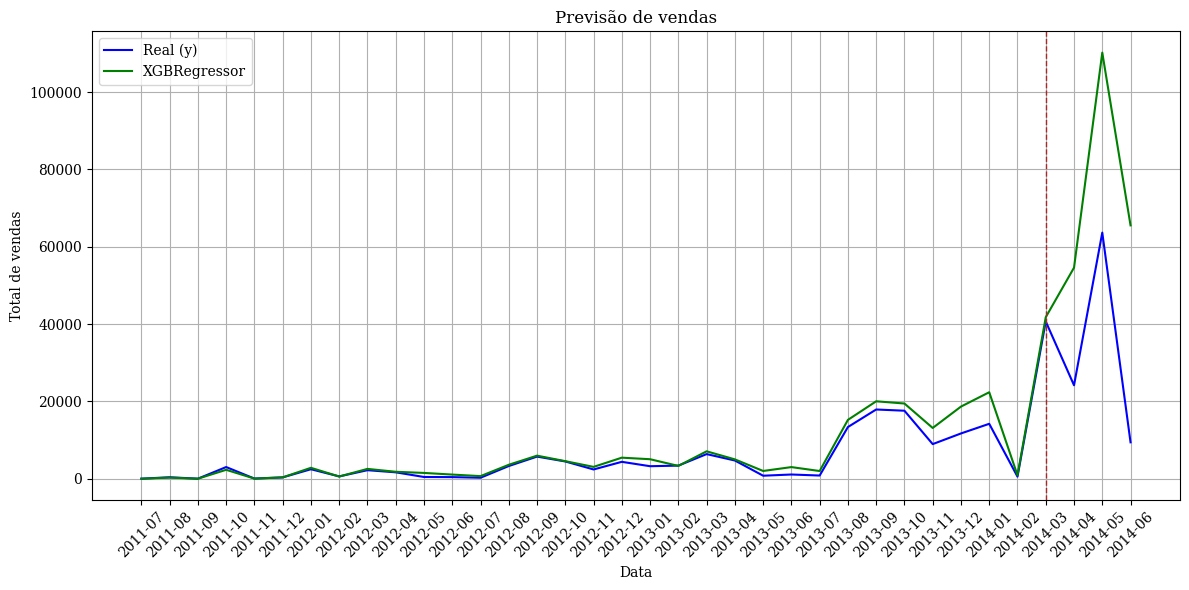

In [113]:
plt.figure(figsize=(12, 6))

plt.plot(grouped_results['month_year'].astype(str), grouped_results['y'], label='Real (y)', color='blue')

plt.plot(grouped_results['month_year'].astype(str), grouped_results['y_pred'], label='XGBRegressor', color='green')

# Adicionar marcador onde inicia os 3 meses finais
end_date = grouped_results['month_year'].max().to_timestamp()
start_date = end_date - pd.DateOffset(months=3)
plt.axvline(x=start_date.strftime('%Y-%m'), color='brown', linestyle='--', linewidth=1)


plt.title('Previsão de vendas')
plt.xlabel('Data')
plt.ylabel('Total de vendas')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Os resultados indicam que o XGBoostRegressor é o modelo mais eficaz para este conjunto de dados, apresentando o menor MAE, MSE e RMSE.

## 9 - Demanda por centro de distribuição

- predict_demand: Dados projetados para os últimos três meses.
- previous_demand: Valores dos três meses que precedem o período das previsões para comparação e análise.



In [114]:
last_date = predictions['ds'].max()

last_three_months = last_date - pd.DateOffset(months=3)
predict_demand = predictions[(predictions['ds'] > last_three_months) & (predictions['ds'] <= last_date)]

six_months_before_last_three = last_three_months - pd.DateOffset(months=6)
previous_demand = predictions[(predictions['ds'] > six_months_before_last_three) & (predictions['ds'] <= last_three_months)]


Separar entre Estados Unidos e uutros países

In [115]:
predict_demand['group'] = predict_demand['unique_id'].apply(
    lambda x: 'USA_Provinces' if 'United States' in x else 'Other_Countries'
)
previous_demand['group'] = previous_demand['unique_id'].apply(
    lambda x: 'USA_Provinces' if 'United States' in x else 'Other_Countries'
)

In [116]:
grouped_predict_demand = predict_demand.groupby('group').agg(
    predict_demand=('AutoARIMA', 'sum')
).reset_index()

grouped_previous_demand = previous_demand.groupby('group').agg(
    previous_demand=('y', 'sum')
).reset_index()

growth_comparison = grouped_predict_demand.merge(grouped_previous_demand, on='group')
growth_comparison['growth_percentage'] = (
    (growth_comparison['predict_demand'] - growth_comparison['previous_demand'])
    / growth_comparison['previous_demand']
) * 100

In [117]:
growth_comparison = growth_comparison[['group', 'previous_demand', 'predict_demand', 'growth_percentage']]
growth_comparison

,group,previous_demand,predict_demand,growth_percentage
0,Other_Countries,13595,62855.234375,362.340819
1,USA_Provinces,16617,48248.824219,190.358213


O grupo "Outros Países" apresentou um crescimento percentual maior em demanda, com uma variação de 362%, comparado aos 190% das EUA. Portanto, "Outros Países" teve um crescimento mais expressivo nos três meses previstos.

## 10 - Estimativa de zíperes

In [118]:
filtered_glove_product = data[data['product_name'].str.lower().str.contains('glove', na=False)]

gloves_product_list = filtered_glove_product['product_name'].unique()

print(gloves_product_list)

['Full-Finger Gloves, M' 'Half-Finger Gloves, L' 'Full-Finger Gloves, S'
 'Half-Finger Gloves, M' 'Full-Finger Gloves, L' 'Half-Finger Gloves, S']


In [119]:
def contains_keyword(unique_id, keywords):
    return any(keyword in unique_id.lower() for keyword in keywords)

In [120]:
gloves_keywords = [name.lower() for name in gloves_product_list]

filtered_gloves = predictions[predictions['unique_id'].apply(lambda x: contains_keyword(x, gloves_keywords))]

In [121]:
latest_date = predictions['ds'].max()

last_three_months = latest_date - pd.DateOffset(months=3)

In [122]:
filtered_predictions = filtered_gloves[filtered_gloves['ds'] > last_three_months]
gloves_demand = filtered_predictions['AutoARIMA'].sum()

In [123]:
print(f"A demanda de luvas para os últimos três meses é de {gloves_demand.round()} unidades.")
print(f"O fabricante deve pedir aproximadamente {(gloves_demand * 2).round()} unidades de zíperes.")

A demanda de luvas para os últimos três meses é de 261.0 unidades.
O fabricante deve pedir aproximadamente 522.0 unidades de zíperes.
